
# "Polish companies bankruptcy" dataset processing

- Dataset source: https://archive.ics.uci.edu/dataset/365/polish+companies+bankruptcy+data


## Dataset Analysys 

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import NamedTuple, List, Dict, Any
from IPython.display import display
from pandas import DataFrame
from ucimlrepo import fetch_ucirepo
from scipy import stats
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import (
    Pipeline as ImbPipeline,
)


# Type definitions from:
# https://github.com/uci-ml-repo/ucimlrepo?tab=readme-ov-file#parameters
class UciMlData(NamedTuple):
    ids: DataFrame
    features: DataFrame
    targets: DataFrame
    original: DataFrame
    headers: List[str]


class UciMlDataset(NamedTuple):
    data: UciMlData
    metadata: Dict[str, Any]
    variables: DataFrame

In [4]:
# Dataset: Polish companies bankruptcy
# Source: https://archive.ics.uci.edu/dataset/365/polish+companies+bankruptcy+data

polish_companies_bankruptcy: UciMlDataset = fetch_ucirepo(id=365)

X_all = polish_companies_bankruptcy.data.features
y_all = polish_companies_bankruptcy.data.targets

In [5]:
display(X_all.head())
display(y_all.head())
display(pd.DataFrame(X_all.dtypes).T)

print("Number of features: ", X_all.shape[1])
print("Number of samples: ", X_all.shape[0])
print("Feature types: ", X_all.dtypes.unique())

,year,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,A55,A56,A57,A58,A59,A60,A61,A62,A63,A64
0,1,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,...,348690.0,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277
1,1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,...,2304.6,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870
2,1,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,...,6332.7,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078
3,1,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,...,20545.0,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497
4,1,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,...,3186.6,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980


,class
0,0
1,0
2,0
3,0
4,0


,year,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,A55,A56,A57,A58,A59,A60,A61,A62,A63,A64
0,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


Number of features:  65
Number of samples:  43405
Feature types:  [dtype('int64') dtype('float64')]


In [6]:
# additional feature information
feature_description = pd.DataFrame(
    [
        ["A1", "net profit / total assets"],
        ["A2", "total liabilities / total assets"],
        ["A3", "working capital / total assets"],
        ["A4", "current assets / short-term liabilities"],
        [
            "A5",
            "[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365",
        ],
        ["A6", "retained earnings / total assets"],
        ["A7", "EBIT / total assets"],
        ["A8", "book value of equity / total liabilities"],
        ["A9", "sales / total assets"],
        ["A10", "equity / total assets"],
        [
            "A11",
            "(gross profit + extraordinary items + financial expenses) / total assets",
        ],
        ["A12", "gross profit / short-term liabilities"],
        ["A13", "(gross profit + depreciation) / sales"],
        ["A14", "(gross profit + interest) / total assets"],
        ["A15", "(total liabilities * 365) / (gross profit + depreciation)"],
        ["A16", "(gross profit + depreciation) / total liabilities"],
        ["A17", "total assets / total liabilities"],
        ["A18", "gross profit / total assets"],
        ["A19", "gross profit / sales"],
        ["A20", "(inventory * 365) / sales"],
        ["A21", "sales (n) / sales (n-1)"],
        ["A22", "profit on operating activities / total assets"],
        ["A23", "net profit / sales"],
        ["A24", "gross profit (in 3 years) / total assets"],
        ["A25", "(equity - share capital) / total assets"],
        ["A26", "(net profit + depreciation) / total liabilities"],
        ["A27", "profit on operating activities / financial expenses"],
        ["A28", "working capital / fixed assets"],
        ["A29", "logarithm of total assets"],
        ["A30", "(total liabilities - cash) / sales"],
        ["A31", "(gross profit + interest) / sales"],
        ["A32", "(current liabilities * 365) / cost of products sold"],
        ["A33", "operating expenses / short-term liabilities"],
        ["A34", "operating expenses / total liabilities"],
        ["A35", "profit on sales / total assets"],
        ["A36", "total sales / total assets"],
        ["A37", "(current assets - inventories) / long-term liabilities"],
        ["A38", "constant capital / total assets"],
        ["A39", "profit on sales / sales"],
        ["A40", "(current assets - inventory - receivables) / short-term liabilities"],
        [
            "A41",
            "total liabilities / ((profit on operating activities + depreciation) * (12/365))",
        ],
        ["A42", "profit on operating activities / sales"],
        ["A43", "rotation receivables + inventory turnover in days"],
        ["A44", "(receivables * 365) / sales"],
        ["A45", "net profit / inventory"],
        ["A46", "(current assets - inventory) / short-term liabilities"],
        ["A47", "(inventory * 365) / cost of products sold"],
        [
            "A48",
            "EBITDA (profit on operating activities - depreciation) / total assets",
        ],
        ["A49", "EBITDA (profit on operating activities - depreciation) / sales"],
        ["A50", "current assets / total liabilities"],
        ["A51", "short-term liabilities / total assets"],
        ["A52", "(short-term liabilities * 365) / cost of products sold)"],
        ["A53", "equity / fixed assets"],
        ["A54", "constant capital / fixed assets"],
        ["A55", "working capital"],
        ["A56", "(sales - cost of products sold) / sales"],
        [
            "A57",
            "(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation)",
        ],
        ["A58", "total costs /total sales"],
        ["A59", "long-term liabilities / equity"],
        ["A60", "sales / inventory"],
        ["A61", "sales / receivables"],
        ["A62", "(short-term liabilities *365) / sales"],
        ["A63", "sales / short-term liabilities"],
        ["A64", "sales / fixed assets"],
    ],
    columns=["Feature", "Description"],
)

feature_description.set_index("Feature", inplace=True)
feature_description.index.name = None

display(feature_description)

,Description
A1,net profit / total assets
A2,total liabilities / total assets
A3,working capital / total assets
A4,current assets / short-term liabilities
A5,[(cash + short-term securities + receivables -...
...,...
A60,sales / inventory
A61,sales / receivables
A62,(short-term liabilities *365) / sales
A63,sales / short-term liabilities


## Visualizing the data

In [7]:
# Analyzing each year sample count and missing feature count
year_counts = X_all["year"].value_counts().sort_index()
year_counts_df = year_counts.reset_index()
year_counts_df.columns = ["Year", "Number of Rows"]

missing_counts = []

for year in year_counts_df["Year"]:
    year_data = X_all[X_all["year"] == year]
    missing_counts.append(year_data.isnull().any(axis=1).sum())

year_counts_df["Number of Rows with Missing Features"] = missing_counts

year_counts_df["% of Rows with Missing Features"] = (
    year_counts_df["Number of Rows with Missing Features"]
    / year_counts_df["Number of Rows"]
) * 100

year_counts_df

,Year,Number of Rows,Number of Rows with Missing Features,% of Rows with Missing Features
0,1,7027,3833,54.546748
1,2,10173,6085,59.815197
2,3,10503,5618,53.489479
3,4,9792,5023,51.296977
4,5,5910,2879,48.714044


In [8]:
# Choose only samples from year = 1
# and remove the year column

year = 3
filter_idx = X_all["year"] == year

X = X_all[filter_idx].drop(columns=["year"])
y = y_all[filter_idx]

display(X.head())
display(y.head())

print("Number of features: ", X.shape[1])
print("Number of samples: ", X.shape[0])
print("Feature types: ", X.dtypes.unique())
print("Target types: ", y.dtypes.unique())

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A55,A56,A57,A58,A59,A60,A61,A62,A63,A64
17200,0.174190,0.41299,0.14371,1.3480,-28.9820,0.60383,0.219460,1.1225,1.1961,0.46359,...,127000.0,0.163960,0.375740,0.83604,0.000007,9.7145,6.2813,84.291,4.3303,4.0341
17201,0.146240,0.46038,0.28230,1.6294,2.5952,0.00000,0.171850,1.1721,1.6018,0.53962,...,3387.8,0.027516,0.271000,0.90108,0.000000,5.9882,4.1103,102.190,3.5716,5.9500
17202,0.000595,0.22612,0.48839,3.1599,84.8740,0.19114,0.004572,2.9881,1.0077,0.67566,...,20453.0,0.007639,0.000881,0.99236,0.000000,6.7742,3.7922,64.846,5.6287,4.4581
17203,0.024526,0.43236,0.27546,1.7833,-10.1050,0.56944,0.024526,1.3057,1.0509,0.56453,...,5012.6,0.048398,0.043445,0.95160,0.142980,4.2286,5.0528,98.783,3.6950,3.4844
17204,0.188290,0.41504,0.34231,1.9279,-58.2740,0.00000,0.233580,1.4094,1.3393,0.58496,...,13730.0,0.176480,0.321880,0.82635,0.073039,2.5912,7.0756,100.540,3.6303,4.6375


,class
17200,0
17201,0
17202,0
17203,0
17204,0


Number of features:  64
Number of samples:  10503
Feature types:  [dtype('float64')]
Target types:  [dtype('int64')]


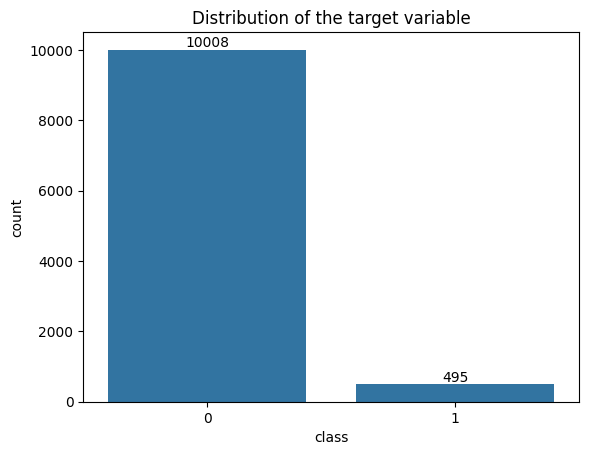

1 - Bankrupt, 0 - Not bankrupt


In [9]:
# Distribution of the target variable
ax = sns.countplot(x=y.columns[0], data=y)
plt.title("Distribution of the target variable")
abs_values = y["class"].value_counts().values
ax.bar_label(ax.containers[0], labels=abs_values, label_type="edge")
plt.show()
print("1 - Bankrupt, 0 - Not bankrupt")

In [10]:
# Summary statistics of the features
min_values = np.min(X, axis=0)
max_values = np.max(X, axis=0)
ranges = max_values - min_values
variances = np.var(X, axis=0)
mean_values = np.mean(X, axis=0)

df = pd.DataFrame(
    {
        "Min Value": min_values,
        "Max Value": max_values,
        "Range": ranges,
        "Variance": variances,
        "Mean": mean_values,
    }
)

display(df)
print(df)

,Min Value,Max Value,Range,Variance,Mean
A1,-1.769200e+01,52.652,7.034400e+01,4.196008e-01,0.052844
A2,0.000000e+00,480.730,4.807300e+02,4.130293e+01,0.619911
A3,-4.797300e+02,17.708,4.974380e+02,4.121320e+01,0.095490
A4,2.080200e-03,53433.000,5.343300e+04,2.742271e+05,9.980499
A5,-1.190000e+07,685000.000,1.258500e+07,1.405316e+10,-1347.355061
...,...,...,...,...,...
A60,0.000000e+00,3660000.000,3.660000e+06,1.380590e+09,571.395839
A61,-6.590300e+00,4470.400,4.476990e+03,7.005709e+03,13.935361
A62,-2.340000e+06,1070000.000,3.410000e+06,6.763327e+08,134.866817
A63,-1.562200e-04,1974.500,1.974500e+03,9.870655e+02,9.095149


        Min Value    Max Value         Range      Variance         Mean
A1  -1.769200e+01       52.652  7.034400e+01  4.196008e-01     0.052844
A2   0.000000e+00      480.730  4.807300e+02  4.130293e+01     0.619911
A3  -4.797300e+02       17.708  4.974380e+02  4.121320e+01     0.095490
A4   2.080200e-03    53433.000  5.343300e+04  2.742271e+05     9.980499
A5  -1.190000e+07   685000.000  1.258500e+07  1.405316e+10 -1347.355061
..            ...          ...           ...           ...          ...
A60  0.000000e+00  3660000.000  3.660000e+06  1.380590e+09   571.395839
A61 -6.590300e+00     4470.400  4.476990e+03  7.005709e+03    13.935361
A62 -2.340000e+06  1070000.000  3.410000e+06  6.763327e+08   134.866817
A63 -1.562200e-04     1974.500  1.974500e+03  9.870655e+02     9.095149
A64 -1.023000e-04    21499.000  2.149900e+04  1.834216e+05    35.766800

[64 rows x 5 columns]


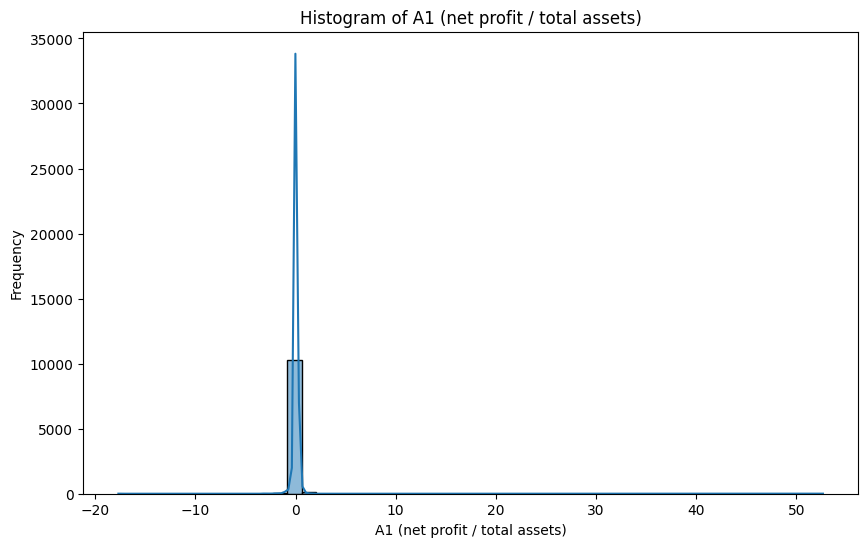

In [11]:
# Histogram of the feature A1
feature_name = "A1"
feature_desc = feature_description["Description"][feature_name]

data = X[feature_name]
plt.figure(figsize=(10, 6))
sns.histplot(data, bins=50, kde=True)
plt.title(f"Histogram of {feature_name} ({feature_desc})")
plt.xlabel(f"{feature_name} ({feature_desc})")
plt.ylabel("Frequency")

plt.show()

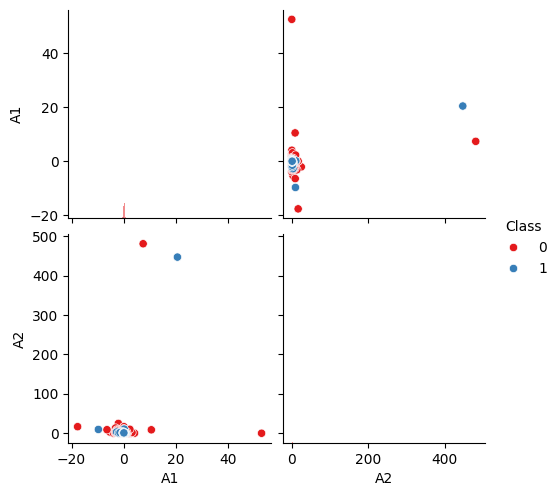

In [12]:
def draw_pairplot(X: pd.DataFrame, y: pd.DataFrame) -> None:
    temp_df = X.assign(Class=y.values)
    sns.pairplot(temp_df, hue="Class", palette="Set1", diag_kind="hist")
    plt.show()


subset_features = ["A1", "A2"]
draw_pairplot(X[subset_features], y)

## Data Preprocessing

In [13]:
display(X.describe())

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A55,A56,A57,A58,A59,A60,A61,A62,A63,A64
count,10503.000000,10503.000000,10503.000000,10485.000000,1.047800e+04,10503.000000,10503.000000,10489.000000,10500.000000,10503.000000,...,1.050300e+04,10460.000000,10503.000000,10474.000000,10503.000000,9.911000e+03,10486.000000,1.046000e+04,10485.000000,10275.000000
mean,0.052844,0.619911,0.095490,9.980499,-1.347355e+03,-0.121159,0.065624,19.140113,1.819254,0.366093,...,6.638015e+03,-0.530082,-0.014817,3.848794,1.429319,5.713958e+02,13.935361,1.348668e+02,9.095149,35.766800
std,0.647797,6.427041,6.420056,523.691951,1.185517e+05,6.970625,0.651152,717.756745,7.581659,6.428603,...,5.986270e+04,55.978608,18.684047,190.201224,77.273270,3.715816e+04,83.704103,2.600764e+04,31.419096,428.298315
min,-17.692000,0.000000,-479.730000,0.002080,-1.190000e+07,-508.120000,-17.692000,-2.081800,-1.215700,-479.730000,...,-7.510000e+05,-5691.700000,-1667.300000,-198.690000,-172.070000,0.000000e+00,-6.590300,-2.340000e+06,-0.000156,-0.000102
25%,0.000686,0.253955,0.017461,1.040100,-5.207075e+01,0.000000,0.002118,0.431270,1.011275,0.297340,...,1.462100e+01,0.005137,0.006796,0.875560,0.000000,5.533150e+00,4.486075,4.073700e+01,3.062800,2.023350
50%,0.043034,0.464140,0.198560,1.605600,1.579300e+00,0.000000,0.050945,1.111000,1.199000,0.515500,...,8.822900e+02,0.051765,0.106880,0.953060,0.002976,9.952100e+00,6.677300,7.066400e+01,5.139200,4.059300
75%,0.123805,0.689330,0.419545,2.959500,5.608400e+01,0.072584,0.142275,2.857100,2.059100,0.725635,...,4.348900e+03,0.130010,0.271310,0.995927,0.240320,2.093600e+01,10.587500,1.182200e+02,8.882600,9.682750
max,52.652000,480.730000,17.708000,53433.000000,6.850000e+05,45.533000,52.652000,53432.000000,740.440000,11.837000,...,3.380000e+06,293.150000,552.640000,18118.000000,7617.300000,3.660000e+06,4470.400000,1.070000e+06,1974.500000,21499.000000


## Missing values

Number of features with missing values:  44


,3,4,7,8,11,12,14,15,16,18,...,51,52,53,55,57,59,60,61,62,63
Feature,A4,A5,A8,A9,A12,A13,A15,A16,A17,A19,...,A52,A53,A54,A56,A58,A60,A61,A62,A63,A64
Missing Values,18,25,14,3,18,43,8,14,14,43,...,86,228,228,43,29,592,17,43,18,228


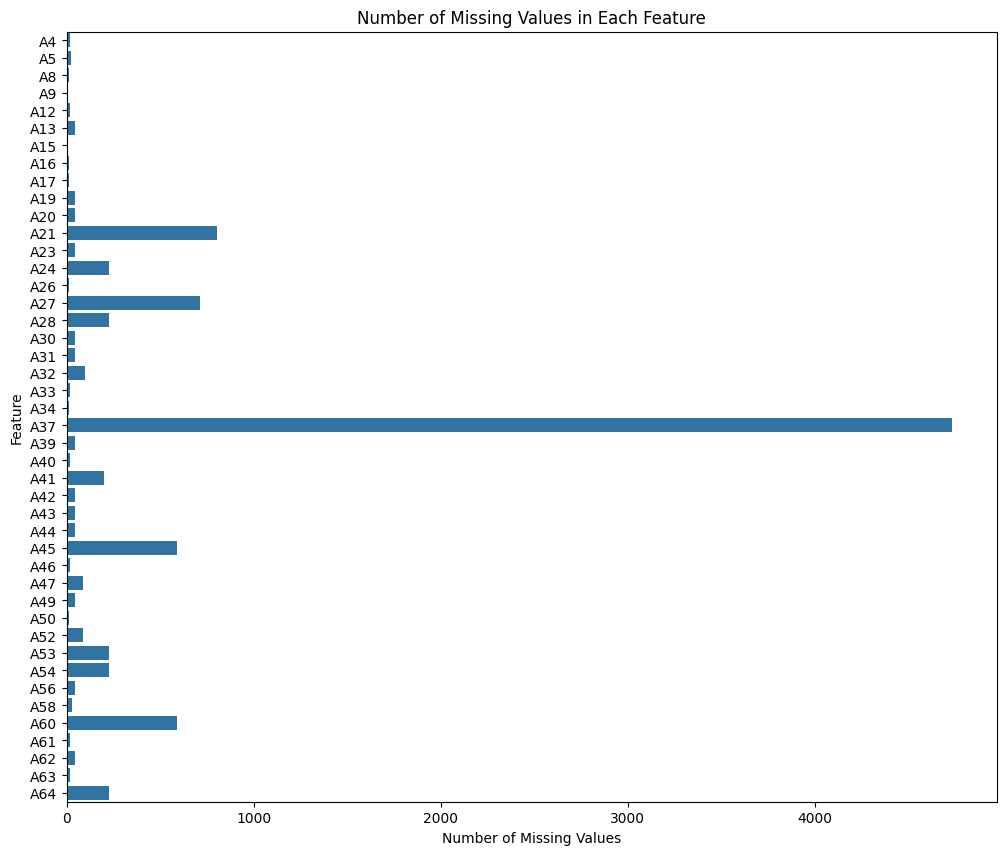

A37 desc: (current assets - inventories) / long-term liabilities
Number of missing values: 9888
Number of rows with missing values: 5618


In [14]:
missing_values = X.isnull().sum().reset_index()
missing_values = missing_values[missing_values[0] > 0]
missing_values.columns = ["Feature", "Missing Values"]

print("Number of features with missing values: ", missing_values.shape[0])
display(missing_values.T)

plt.figure(figsize=(12, 10))
sns.barplot(x="Missing Values", y="Feature", data=missing_values)
plt.title("Number of Missing Values in Each Feature")
plt.xlabel("Number of Missing Values")
plt.ylabel("Feature")
plt.show()

print(f"A37 desc: {feature_description['Description']['A37']}")

number_of_missing_values = sum(missing_values["Missing Values"].values)
print(f"Number of missing values: {number_of_missing_values}")
number_of_rows_with_missing_values = X.isnull().any(axis=1).sum()
print(f"Number of rows with missing values: {number_of_rows_with_missing_values}")

In [15]:
# drop column A37
print("Drop column A37")
X_clean = X.drop(columns=["A37"])

number_of_rows_with_missing_values_after_removal = X_clean.isnull().any(axis=1).sum()
print(
    f"Number of missing values after removal: {number_of_rows_with_missing_values_after_removal}"
)

# drop rest of samples with missing values
print("Drop rest of samples with missing values")
X_clean = X_clean.dropna()
y_clean = y.loc[X_clean.index]

sample_count = pd.DataFrame(
    {
        "Number of samples before removal": [X.shape[0]],
        "Number of samples after removal": [X_clean.shape[0]],
    }
)
display(sample_count)

Drop column A37
Number of missing values after removal: 2269
Drop rest of samples with missing values


,Number of samples before removal,Number of samples after removal
0,10503,8234


## Removing outliers

### IQR method

In [16]:
def remove_outliers(
    X: pd.DataFrame, y: pd.DataFrame
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Remove outliers from the dataset using the IQR method.
    """
    q1 = X.quantile(0.25)
    q2 = X.quantile(0.75)
    iqr = q2 - q1

    iqr_m = 3
    lower_bound = q1 - iqr_m * iqr
    upper_bound = q2 + iqr_m * iqr

    outlier_indices = X[((X < lower_bound) | (X > upper_bound)).any(axis=1)].index

    X_clean = X.drop(outlier_indices)
    y_clean = y.drop(outlier_indices)

    return X_clean, y_clean


X_clean_no_outliers, y_clean_no_outliers = remove_outliers(X_clean, y_clean)

print(f"Original X_clean shape: {X_clean.shape}")
print(f"New X_clean shape after removing outliers: {X_clean_no_outliers.shape}")
print(f"Original y_clean shape: {y_clean.shape}")
print(f"New y_clean shape after removing outliers: {y_clean_no_outliers.shape}")

Original X_clean shape: (8234, 63)
New X_clean shape after removing outliers: (2628, 63)
Original y_clean shape: (8234, 1)
New y_clean shape after removing outliers: (2628, 1)


**IQR method caused a significant loss of data. Let's try the Z-score method.**

### Z-score method

In [17]:
def remove_outliers(
    X: pd.DataFrame, y: pd.DataFrame
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Remove outliers from the dataset using Z-score method
    """
    z_scores = np.abs(stats.zscore(X))
    threshold = 3
    outliers = (z_scores > threshold).any(axis=1)
    X_no_outliers = X[~outliers]
    y_no_outliers = y.loc[X_no_outliers.index]
    return X_no_outliers, y_no_outliers


X_clean_no_outliers, y_clean_no_outliers = remove_outliers(X_clean, y_clean)

print(f"Original X_clean shape: {X_clean.shape}")
print(f"New X_clean shape after removing outliers: {X_clean_no_outliers.shape}")
print(f"Original y_clean shape: {y_clean.shape}")
print(f"New y_clean shape after removing outliers: {y_clean_no_outliers.shape}")

Original X_clean shape: (8234, 63)
New X_clean shape after removing outliers: (7425, 63)
Original y_clean shape: (8234, 1)
New y_clean shape after removing outliers: (7425, 1)


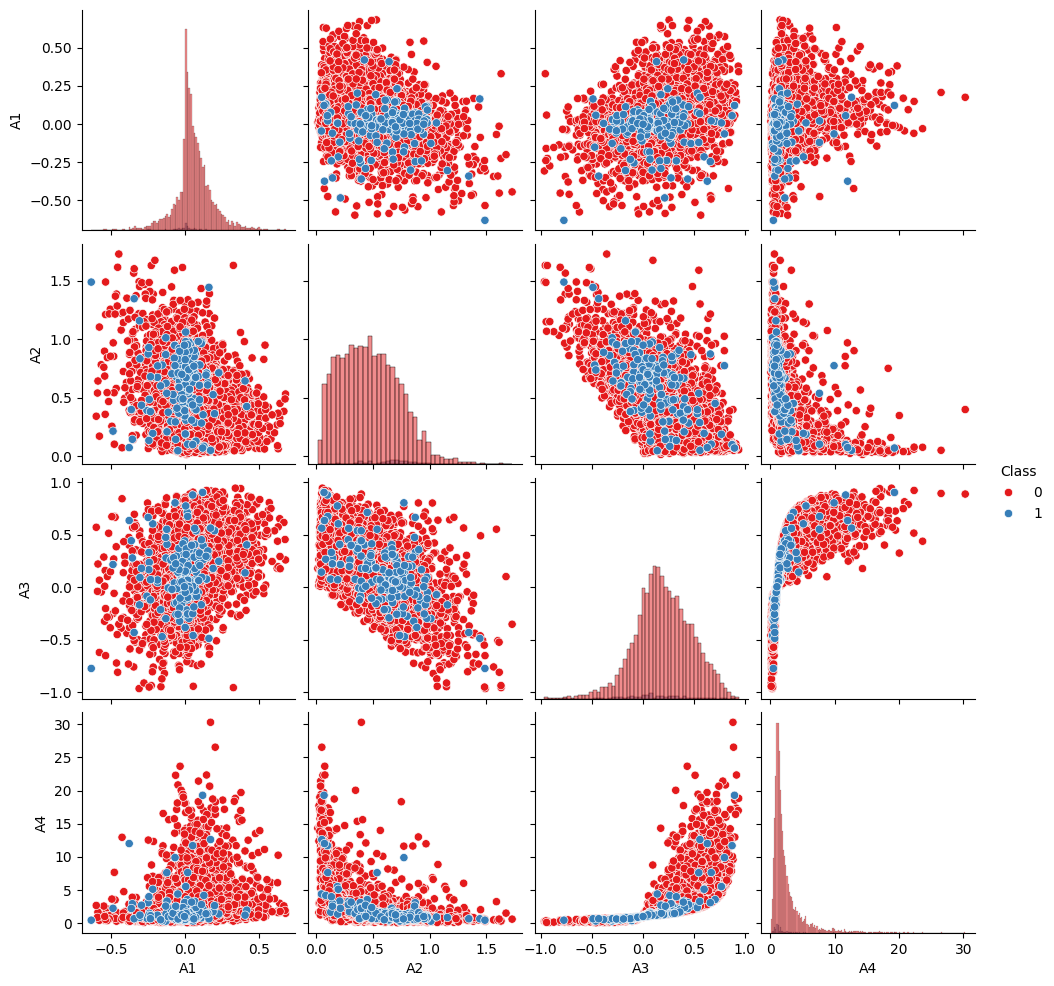

In [18]:
subset_features = ["A1", "A2", "A3", "A4"]
draw_pairplot(X_clean_no_outliers[subset_features], y_clean_no_outliers)

# Standarize and normalize the data

In [19]:
def standardize_features(X: pd.DataFrame) -> pd.DataFrame:
    """
    Standardize the features of the dataset.
    """
    scaler = StandardScaler()
    X_scaled_array = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled_array, index=X.index, columns=X.columns)
    return X_scaled


# compared to normalization, standardization is less affected by outliers
# standardization is more suitable for algorithms that assume normally distributed data
# standardization is more suitable for algorithms that assume zero-centered data
X_standardized = standardize_features(X_clean_no_outliers)
y_standardized = y_clean_no_outliers

In [20]:
def normalize_features(X: pd.DataFrame) -> pd.DataFrame:
    """
    Normalize the features of the dataset.
    """
    scaler = MinMaxScaler()
    X_normalized_array = scaler.fit_transform(X)
    X_normalized = pd.DataFrame(X_normalized_array, index=X.index, columns=X.columns)
    return X_normalized


X_normalized = normalize_features(X_clean_no_outliers)

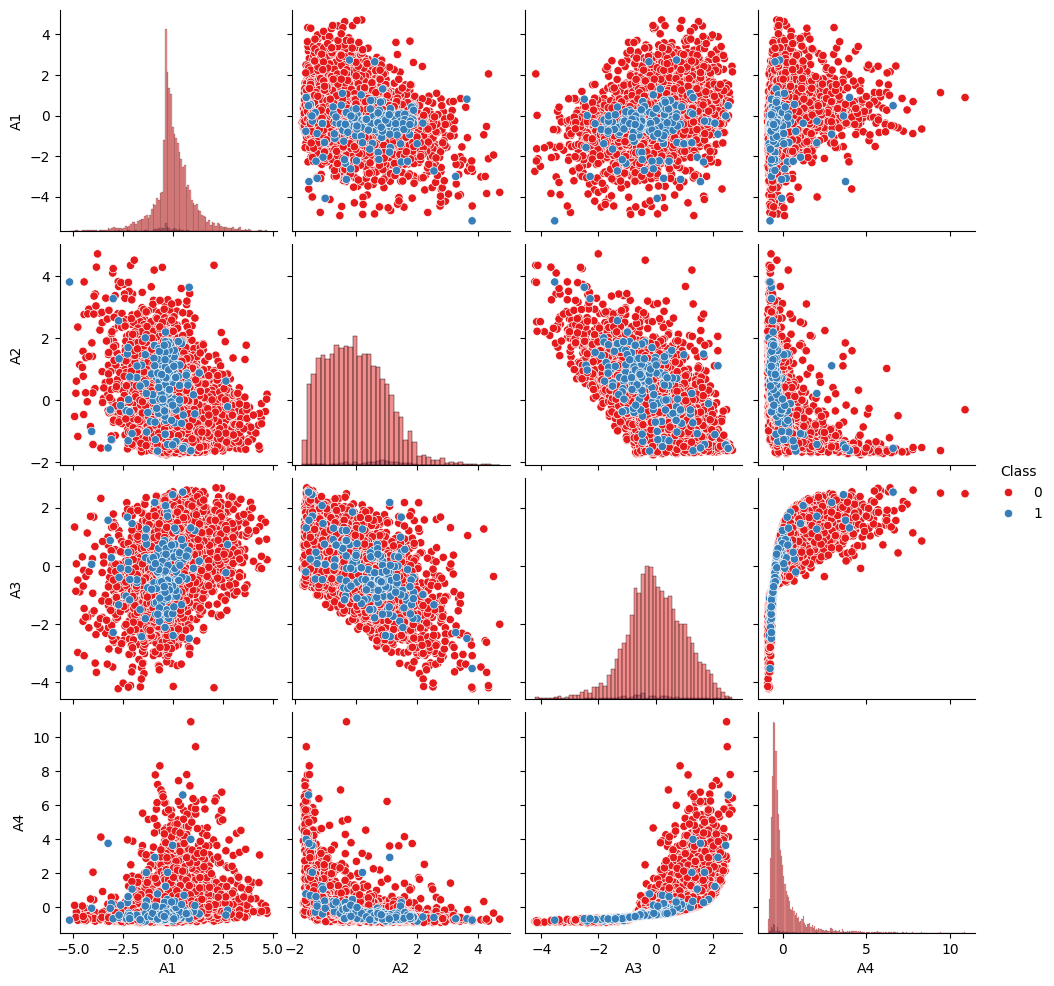

In [21]:
subset_features = ["A1", "A2", "A3", "A4"]
draw_pairplot(X_standardized[subset_features], y_clean_no_outliers)

# Principal Component Analysis (PCA)

In [22]:
def plot_pca_2d(
    X: pd.DataFrame, y: pd.DataFrame, target_column: str, title: str = "2D PCA"
) -> None:
    """
    Perform PCA on the dataset and plot the first two principal components.

    Parameters:
    X (pd.DataFrame): The input features as a pandas DataFrame.
    y (pd.DataFrame): The target DataFrame. Ensure y's index aligns with X's index and it has the target column.
    target_column (str): The name of the target column in y DataFrame.
    title (str): Title for the plot.
    """
    if target_column not in y.columns:
        raise ValueError(f"{target_column} is not a column in the provided DataFrame.")

    if not X.index.equals(y.index):
        raise ValueError("The indices of X and y must match.")

    y_series = y[target_column]

    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(X)

    pca_df = pd.DataFrame(
        data=principal_components,
        columns=["Principal Component 1", "Principal Component 2"],
    )
    pca_df[target_column] = y_series.values

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x="Principal Component 1",
        y="Principal Component 2",
        hue=target_column,
        palette="Set1",
        data=pca_df,
    )
    plt.title(title)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title=target_column)
    plt.show()

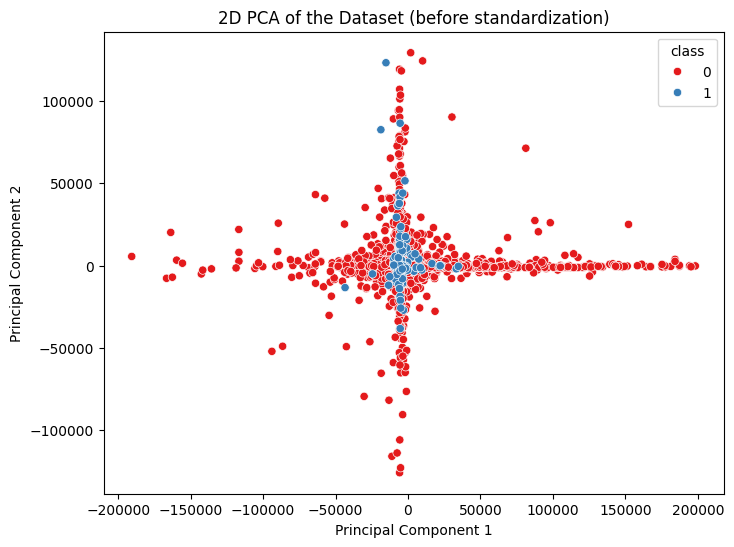

In [23]:
plot_pca_2d(
    X_clean_no_outliers,
    y_clean_no_outliers,
    "class",
    "2D PCA of the Dataset (before standardization)",
)

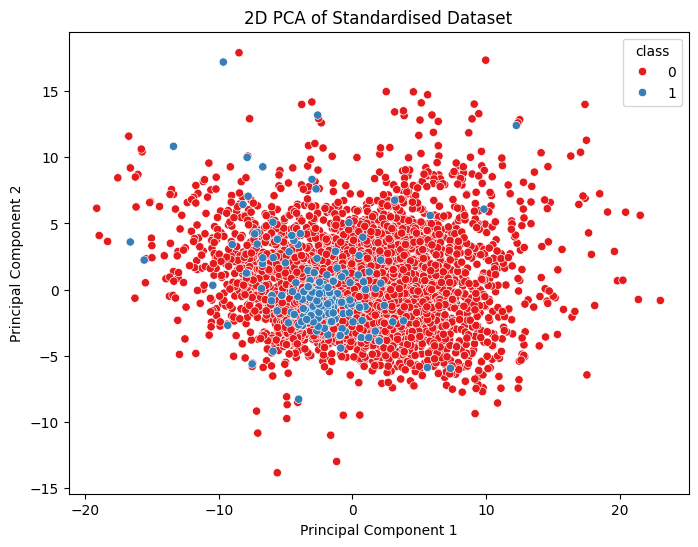

In [24]:
# It's better to perform standardization before PCA
plot_pca_2d(
    X_standardized, y_clean_no_outliers, "class", "2D PCA of Standardised Dataset"
)

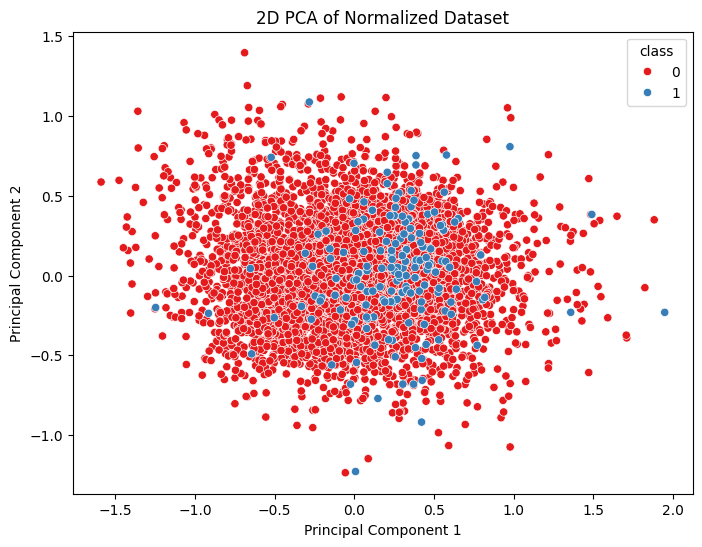

In [25]:
# It's better to perform standardization before PCA
plot_pca_2d(X_normalized, y_clean_no_outliers, "class", "2D PCA of Normalized Dataset")

In [26]:
def plot_tsne(
    X: pd.DataFrame,
    y: pd.DataFrame,
    target_column: str,
    title: str = "t-SNE plot",
    perplexity: int = 30,
    n_iter: int = 1000,
) -> None:
    """
    Apply t-SNE on the dataset and plot the results in a 2D scatter plot.

    Parameters:
    X (pd.DataFrame): The input features as a pandas DataFrame.
    y (pd.DataFrame): The target DataFrame. Ensure y's index aligns with X's index and it has the target column.
    target_column (str): The name of the target column in the y DataFrame.
    title (str): Title for the plot.
    perplexity (int): The perplexity parameter for t-SNE.
    n_iter (int): The number of iterations for optimization.
    """
    if target_column not in y.columns:
        raise ValueError(f"{target_column} is not a column in the provided DataFrame.")

    if not X.index.equals(y.index):
        raise ValueError("The indices of X and y must match.")

    y_series = y[target_column]

    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=42)
    tsne_results = tsne.fit_transform(X)

    tsne_df = pd.DataFrame(data=tsne_results, columns=["t-SNE 1", "t-SNE 2"])
    tsne_df[target_column] = y_series.values

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x="t-SNE 1", y="t-SNE 2", hue=target_column, palette="Set1", data=tsne_df
    )
    plt.title(title)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.legend(title=target_column)
    plt.show()

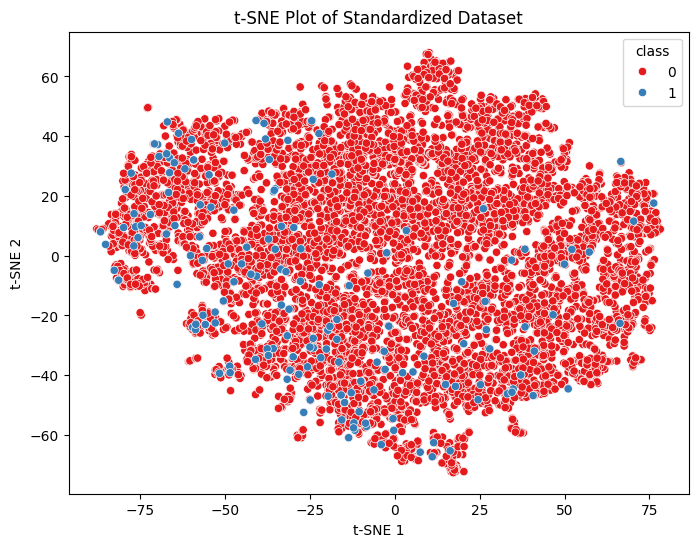

In [27]:
plot_tsne(
    X_standardized, y_clean_no_outliers, "class", "t-SNE Plot of Standardized Dataset"
)

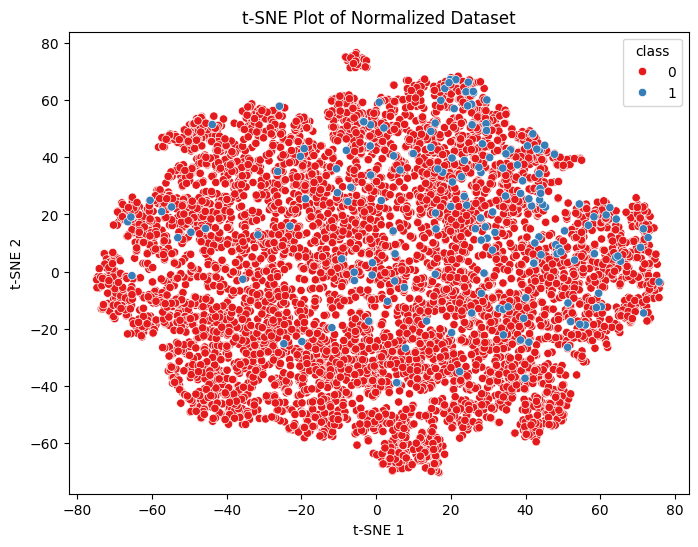

In [28]:
plot_tsne(
    X_normalized, y_clean_no_outliers, "class", "t-SNE Plot of Normalized Dataset"
)

# Clasification or clustering algorithms

## Extreme Gradient Boosing (XGBoost/EXGB)

In [65]:
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(
    X_clean_no_outliers, y_clean_no_outliers, test_size=0.2, random_state=42
)


def run_classification_pipeline(
    X: pd.DataFrame, y: pd.DataFrame, pipeline: Pipeline
) -> dict:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    print(classification_report(y_test, y_pred))
    return classification_report(y_test, y_pred, output_dict=True)

In [68]:
pipeline_xgb = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("classifier", XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)),
    ]
)

print("XGBoost Classifier")
_ = run_classification_pipeline(X_clean_no_outliers, y_clean_no_outliers, pipeline_xgb)

# precision = relevant instances retrieved / total instances retrieved
# recall = relevant instances retrieved / total instances relevant

# support - number of occurrences of each class in y
# f1-score - harmonic mean of precision and recall

XGBoost Classifier
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1444
           1       1.00      0.10      0.18        41

    accuracy                           0.98      1485
   macro avg       0.99      0.55      0.58      1485
weighted avg       0.98      0.98      0.96      1485



- Large difference in metrics between classes

Class 0
- high precision and recall for class 0

Class 1
- high precision for class 1
- very low recall for class 0

## Random Forest

In [69]:
pipeline_rf = Pipeline(
    [
        ("standardizer", StandardScaler()),
        ("classifier", RandomForestClassifier(n_estimators=100, random_state=42)),
    ]
)

print("Random Forest Classifier")
_ = run_classification_pipeline(X_clean_no_outliers, y_clean_no_outliers, pipeline_rf)

Random Forest Classifier


/home/piotr/projects/ai/um-l/l-1/venv/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1444
           1       0.25      0.02      0.04        41

    accuracy                           0.97      1485
   macro avg       0.61      0.51      0.51      1485
weighted avg       0.95      0.97      0.96      1485



## Imbalanced dataset problem

Potential techniques for imbalanced data:
    
- Oversampling the minority class (ex. SMOTE (Synthetic Minority Oversampling Technique))
- Undersampling the majority class


In [70]:
pipeline_xgb_smote = ImbPipeline(
    [
        ("scaler", StandardScaler()),
        ("smote", SMOTE(random_state=42)),
        ("classifier", XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)),
    ]
)

print("XGBoost Classifier with SMOTE")
xgb_smote_report = run_classification_pipeline(
    X_clean_no_outliers, y_clean_no_outliers, pipeline_xgb_smote
)

XGBoost Classifier with SMOTE
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      1444
           1       0.14      0.51      0.22        41

    accuracy                           0.90      1485
   macro avg       0.56      0.71      0.58      1485
weighted avg       0.96      0.90      0.93      1485



Class 0:
- precision: small increase from 0.98 to 0.99
- recall: small decrease from 1.00 to 0.91
- f1-score: decrease from 0.95 to 0.95

Class 1:
- precision: large decrease from 1.0 to 0.14 
- recall: large increase from 0.10 to 0.51
- f1-score: increase from 0.18 to 0.22

- more false positivives, less false negatives

## XGBoost with SMOTE without removed outliers

In [76]:
pipeline_xgb_smote_outliers = ImbPipeline(
    [
        ("scaler", StandardScaler()),
        ("smote", SMOTE(random_state=42)),
        ("classifier", XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)),
    ]
)

print("XGBoost with SMOTE and outliers:")
xgb_smote_outliers_report = run_classification_pipeline(
    # pass X and y without removed outliers
    X_clean,
    y_clean,
    pipeline_xgb_smote,
)

XGBoost with SMOTE and outliers:
              precision    recall  f1-score   support

           0       0.98      0.91      0.94      1594
           1       0.16      0.53      0.25        53

    accuracy                           0.90      1647
   macro avg       0.57      0.72      0.60      1647
weighted avg       0.96      0.90      0.92      1647



### XBoost with SMOTE without standardization

In [78]:
pipeline_xgb_smote_no_std = ImbPipeline(
    [
        ("smote", SMOTE(random_state=42)),
        ("classifier", XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)),
    ]
)

print("XGB with SMOTE without standardization:")
xgb_smote_no_std_outliers_report = run_classification_pipeline(
    X_clean_no_outliers,
    y_clean_no_outliers,
    pipeline_xgb_smote_no_std,
)

XGB with SMOTE without standardization:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      1444
           1       0.14      0.44      0.22        41

    accuracy                           0.91      1485
   macro avg       0.56      0.68      0.58      1485
weighted avg       0.96      0.91      0.93      1485



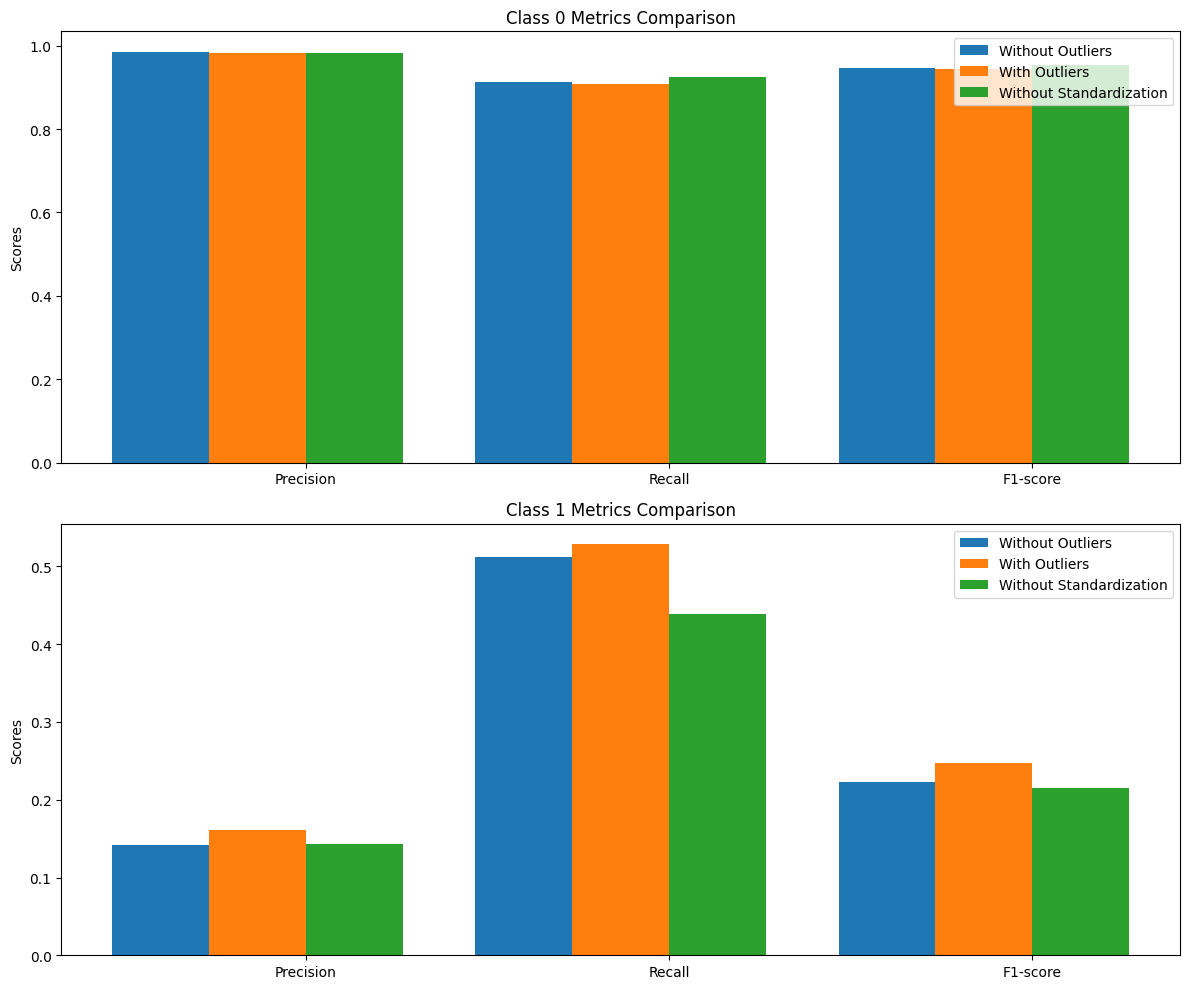

In [81]:
import numpy as np
import matplotlib.pyplot as plt


def compare_classification_reports(*reports, titles):
    """
    Compares multiple classification reports.

    Parameters:
    - reports: Variable length argument list of classification report dictionaries.
    - titles: Titles for each report for legend labeling.
    """
    assert len(reports) == len(titles), "Each report must have a corresponding title."

    labels = ["Precision", "Recall", "F1-score"]
    x = np.arange(len(labels))  # the label locations
    width = 0.8 / len(reports)  # dynamic bar width based on number of reports

    fig, ax = plt.subplots(2, 1, figsize=(12, 10))

    for i, (report, title) in enumerate(zip(reports, titles)):
        class_0_metrics = [
            report["0"]["precision"],
            report["0"]["recall"],
            report["0"]["f1-score"],
        ]
        class_1_metrics = [
            report["1"]["precision"],
            report["1"]["recall"],
            report["1"]["f1-score"],
        ]

        # Positioning of each bar group on the X axis
        offsets = np.arange(-width * len(reports) / 2, width * len(reports) / 2, width)

        ax[0].bar(x + offsets[i], class_0_metrics, width, label=title)
        ax[1].bar(x + offsets[i], class_1_metrics, width, label=title)

    # Set labels, titles, and legends
    ax[0].set_ylabel("Scores")
    ax[0].set_title("Class 0 Metrics Comparison")
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(labels)
    ax[0].legend()

    ax[1].set_ylabel("Scores")
    ax[1].set_title("Class 1 Metrics Comparison")
    ax[1].set_xticks(x)
    ax[1].set_xticklabels(labels)
    ax[1].legend()

    fig.tight_layout()
    plt.show()


compare_classification_reports(
    xgb_smote_report,
    xgb_smote_outliers_report,
    xgb_smote_no_std_outliers_report,
    titles=["Without Outliers", "With Outliers", "Without Standardization"],
)